In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import requests
warnings.filterwarnings('ignore')

from io import BytesIO
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf

## 1. Carga del dataset

In [ ]:
# Importar datos
DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
#df = df.set_index("datetime")

# Validaciones mínimas
expected_cols = {"temperature","humidity","general_diffuse_flows","zone_1"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas en el dataset: {missing}. "
                     f"Columnas disponibles: {df.columns.tolist()}")

print("\nFrecuencia aproximada:", (df.index.to_series().diff().mode().iloc[0]))
print("Filas totales:", len(df))


Frecuencia aproximada: 1.0
Filas totales: 52416


In [ ]:
df.head()

,datetime,temperature,humidity,wind_speed,general_diffuse_flows,zone_1
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,34055.69620
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,29814.68354
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,29128.10127
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,28228.86076
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,27335.69620


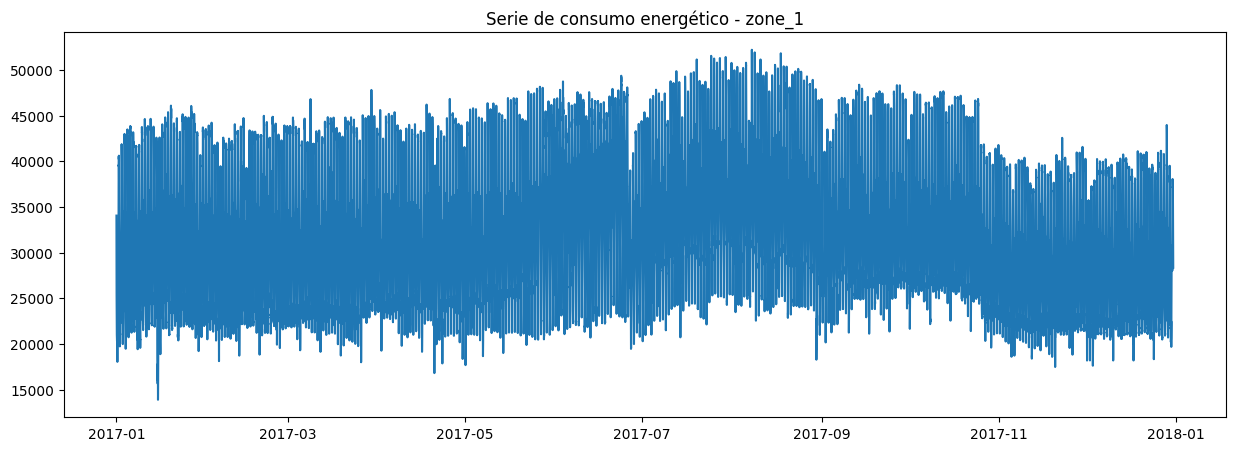

In [ ]:
data = df['zone_1'].values.reshape(-1,1)

plt.figure(figsize=(15,5))
plt.plot(df['datetime'], data)
plt.title("Serie de consumo energético - zone_1")
plt.show()

## 2. Escalado de los datos

In [ ]:
scaler = MinMaxScaler()
data_s = scaler.fit_transform(data)

print("Valores originales:", np.min(data), np.max(data))
print("Valores escalados:", np.min(data_s), np.max(data_s))

Valores originales: 13895.6962 52204.39512
Valores escalados: 0.0 0.9999999999999999


## 3. Entrenamiento

In [ ]:
n = len(data_s)
train_size = int(n*0.8)

x_train = data_s[:train_size]
x_test  = data_s[train_size:]

print(x_train.shape, x_test.shape)

(41932, 1) (10484, 1)


In [ ]:
dim_entrada = x_train.shape[1]  # en este caso es 1 (un valor por tiempo)

entrada= Input(shape=(dim_entrada,))

# Encoder
encoder= Dense(32, activation='relu')(entrada)
encoder= Dense(16, activation='relu')(encoder)

# Latente
latente= Dense(8, activation='relu')(encoder)

# Decoder
decoder= Dense(16, activation='relu')(latente)
decoder= Dense(32, activation='relu')(decoder)

salida= Dense(dim_entrada, activation='sigmoid')(decoder)

autoencoder= Model(inputs=entrada, outputs=salida)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,449 (5.66 KB)

 Trainable params: 1,449 (5.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0565 - val_loss: 0.0024
Epoch 2/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 5/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0021 - val_loss: 6.7377e-04
Epoch 8/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 9/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0026 - val_loss: 4.7061e-04
Epoch 10/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0023 - val_loss: 7.4367e-04
Epoch 11/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0017 - val_loss: 8.0526e-04
Epoch 12/20
656/656 ━━━━━━━━━━━━━━━━

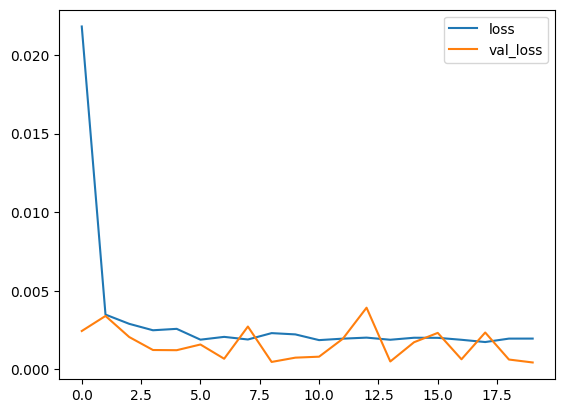

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

historia = autoencoder.fit(x_train, x_train,
                           epochs=20, batch_size=64,
                           validation_data=(x_test, x_test),
                           shuffle=True)

plt.plot(historia.history['loss'], label='loss')
plt.plot(historia.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

La pérdida empieza relativamente alta (~0.022) y cae muy rápido en la primera época. Después de la época 2, se estabiliza alrededor de ~0.002, con ligeras oscilaciones. Esto indica que el autoencoder aprende rápidamente a reconstruir los datos de entrenamiento.

In [ ]:
pred_train = autoencoder.predict(x_train)
pred_test  = autoencoder.predict(x_test)

loss_train = tf.keras.losses.mae(x_train, pred_train).numpy()
loss_test  = tf.keras.losses.mae(x_test, pred_test).numpy()

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## 4. Planteamiento del umbral

In [ ]:
umbral = np.mean(loss_train) + np.std(loss_train)
print("Umbral de anomalía:", umbral)

Umbral de anomalía: 0.0033845375


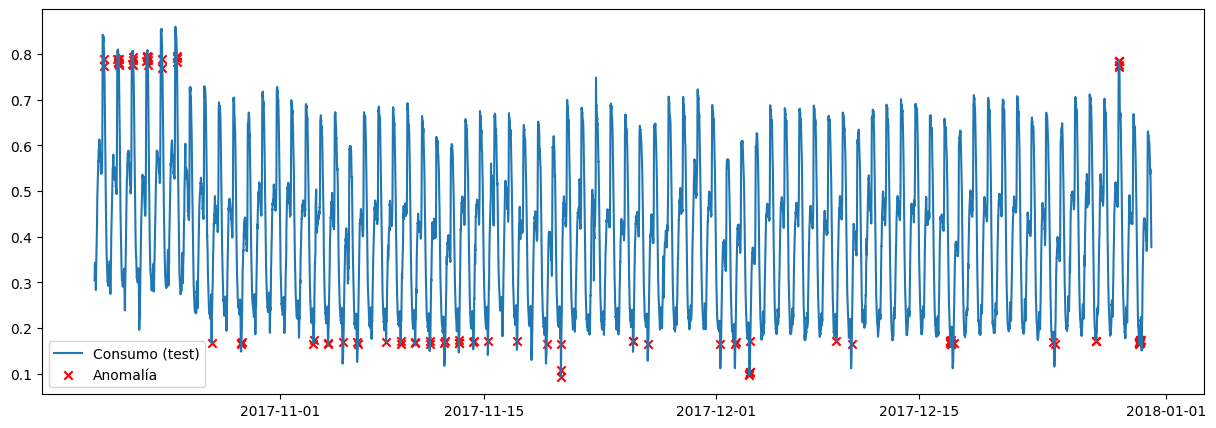

In [ ]:
anomalias = loss_test > umbral

# Graficamos serie vs anomalías
plt.figure(figsize=(15,5))
plt.plot(df['datetime'][train_size:], x_test, label='Consumo (test)')
plt.scatter(df['datetime'][train_size:][anomalias],
            x_test[anomalias], color='red', marker='x', label='Anomalía')
plt.legend()
plt.show()

In [ ]:
def predecir(modelo, datos, umbral):
    reconstrucciones = modelo.predict(datos)
    perdidas = tf.keras.losses.mae(datos, reconstrucciones).numpy()
    prediccion = perdidas >= umbral
    return prediccion

# Función para calcular especificidad
def calcular_especificidad(prediccion, titulo=""):
    FP = np.count_nonzero(prediccion)   # normales marcados como anomalías
    TN = np.count_nonzero(~prediccion)  # normales bien detectados
    esp = 100*TN/(TN+FP)
    print(f"Especificidad {titulo}: {esp:.2f}%")
    return esp


# Predicciones sobre los datos de entrenamiento (asumidos 100% normales)
pred_train = predecir(autoencoder, x_train, umbral)

# Calculamos especificidad
calcular_especificidad(pred_train, titulo="Consumo energético (train)")

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Especificidad Consumo energético (train): 95.86%


95.85996375083468